# Mapping the Sag River Flood by NIR Thresholding
In this notebook, we look at a small subset of the Landsat image. To determine the flood extent, we threshold the NIR band, detecting water at all pixels that are below that threshold.

## Getting started

We first need to install and load packages.

Simply click on the little play button in the following code cells. Do not worry about the details.

In [1]:
!pip install ipympl | grep -v 'already satisfied' # for interactive plots

In [2]:
# Setting up packages
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,3)

# For interactive plotting
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

path0 = Path('/content/drive/My Drive/Colab Notebooks/') # move this to an Amazon bucket

The image we are about to load comprises the reflectance bands B1 through B7, all scaled to reflectance.


We load the image as a numpy array in the second line


In [3]:
# band names
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Loads the image into the refl image array; its shape is (7, height, width)
refl = np.load(path0 / 'sagflood.npy')

## Processing the image

We have identified the NIR band for determining the flood extent. This is band 'B5' for Landsat 8/9. Because Python counts start at 0, its index is 4. The following line extracts this band:

In [4]:
# NIR image of shape (height, width)
refl_nir = refl[4, ...]

To visualize the image using our "natural" false color composite, we extract the corresponding bands. The indices are: 5: SWIR1, 4: NIR, 3: Red.

In [5]:
# RGB image of shape (3, height, width), representing "natural" color composite
refl_natural = refl[(5, 4, 3), ...]

## Visualizing the image

The following two functions are used to visualize the image. The details are not important and go beyond the content of this class, but detailed comments are included if you are interested in learning more.

The first one, *scale_image_percentiles*, takes an RGB image and scales it to the range (0, 1) based on each band's values using percentiles. This is to facilitate visualization.

The second one, *two_panel*, creates an interactive two-panel display.

In [22]:
def scale_image_percentiles(image, p_low=2, p_high=98):
    """
    Scales a 3-band multispectral image to [0, 1] range using adjustable percentiles,
    suitable for display with numpy.imshow.

    Parameters:
        image (numpy.ndarray): A 3D numpy array representing the image,
                               with shape (3, height, width).
        p_low (float): The lower percentile for scaling (default is 2).
        p_high (float): The upper percentile for scaling (default is 98).

    Returns:
        numpy.ndarray: The scaled image with pixel values in the range [0, 1],
                       with shape (3, height, width).
    """
    # Ensure the image is in float format to prevent issues with division
    image = image.astype(np.float32)

    # Calculate the low and high percentiles for each band
    p_low_value = np.percentile(image, p_low, axis=(1, 2), keepdims=True)
    p_high_value = np.percentile(image, p_high, axis=(1, 2), keepdims=True)

    # Scale the image using these percentiles
    scaled_image = (image - p_low_value) / (p_high_value - p_low_value)

    # Clip values to [0, 1] range to handle any values outside this range after scaling
    scaled_image = np.clip(scaled_image, 0, 1)

    return scaled_image

def two_panel(
      image, rgb_image, p_low=2, p_high=98, label='Custom image', scale_image=True):
    """
    Displays a single-band image on the left and an unscaled RGB multispectral image on the right.
    The two axes are linked, and a static grid is added.
    Parameters:
        image (numpy.ndarray): A 2D array with shape (height, width) to be displayed on the left.
        rgb_image (numpy.ndarray): A 3D array with shape (3, height, width) representing the multispectral image.
        p_low (float): The lower percentile for scaling the RGB image (default is 2).
        p_high (float): The upper percentile for scaling the RGB image (default is 98).
        label (string): Label for the left panel
        scale_image (boolean): Applyies percentile scaling to image
    """
    # Scale the RGB image using the provided percentiles
    scaled_rgb_image = scale_image_percentiles(rgb_image, p_low=p_low, p_high=p_high)

    # Transpose the scaled image for correct display in matplotlib
    rgb_image = np.transpose(scaled_rgb_image, (1, 2, 0))

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(bottom=0.08)

    # Display the custom image on the left
    if scale_image and not np.issubdtype(image.dtype, np.unsignedinteger):
        vmin, vmax = np.percentile(image, p_low), np.percentile(image, p_high)
    elif np.issubdtype(image.dtype, np.unsignedinteger):
        vmin, vmax = 0, 1 # for binary image
    else:
        vmin, vmax = -1, 1
    im = axes[0].imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(label)
    axes[0].axis('off')  # Hide the axis

    # Display the RGB image on the right
    axes[1].imshow(rgb_image)
    axes[1].set_title('False Color Composite')
    axes[1].axis('off')  # Hide the axis

    # Link the axes
    def link_axes(ax1, ax2):
        """
        Link the x and y limits of two axes.
        """
        def update_xlim(val):
            ax2.set_xlim(ax1.get_xlim())
            fig.canvas.draw_idle()
        def update_ylim(val):
            ax2.set_ylim(ax1.get_ylim())
            fig.canvas.draw_idle()
        ax1.callbacks.connect('xlim_changed', update_xlim)
        ax1.callbacks.connect('ylim_changed', update_ylim)

    link_axes(axes[0], axes[1])

    # Add a static grid

    def add_static_grid(ax, n_lines=10):
        """
        Add a static grid to the given axis that does not change with zooming.

        Parameters:
            ax (matplotlib.axes.Axes): The axis to which the grid will be added.
            n_lines (int): The number of gridlines
        """
        # Set plotting parameters
        kwplot = {'color': '#ffffcc', 'linewidth': 0.7}

        # Get image dimensions
        xlim = (0, image.shape[1])
        ylim = (0, image.shape[0])

        # Create grid lines
        x_ticks = np.linspace(xlim[0], xlim[1], n_lines)
        y_ticks = np.arange(ylim[0], ylim[1], x_ticks[1] - x_ticks[0])

        for x in x_ticks:
            ax.axvline(x=x, **kwplot)

        for y in y_ticks:
            ax.axhline(y=y, **kwplot)

    add_static_grid(axes[0])
    add_static_grid(axes[1])

    # Add a colorbar if image unless image is a uint image
    if not np.issubdtype(image.dtype, np.unsignedinteger):
        cax = fig.add_axes([0.15, 0.05, 0.2, 0.02])
        fig.colorbar(im, cax=cax, orientation='horizontal')

    # Show the figure
    plt.show()

We will be using interactive plots. You can navigate across the image using the zoom, pan and home options.
![Zoom options](https://matplotlib.org/ipympl/_images/basic.apng)

Let's visualize the NIR image and the natural composite RGB image side by side.

You should recognize the area, as we looked at it earlier.

You can navigate by using the zoom and pan options in the left image.

In [23]:
two_panel(refl_nir, refl_natural, label='NIR reflectance')

Output hidden; open in https://colab.research.google.com to view.

## Selecting a threshold



Setting the threshold is the biggest challenge. We will do this manually.

Let's plot a [histogram](https://en.wikipedia.org/wiki/Histogram) of the NIR reflectance values in our study area.

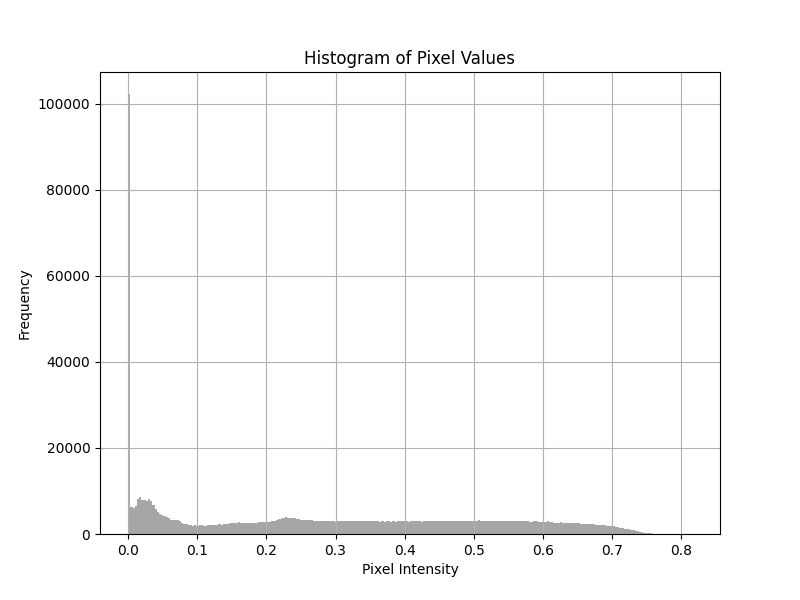

In [8]:
def plot_histogram(image, bins=256):
    """
    Plots the histogram of a grayscale image to help identify a threshold for binary classification.

    Parameters:
        image (numpy.ndarray): A 2D array representing the grayscale image.
        bins (int): The number of bins to use for the histogram (default is 256).
    """
    # Flatten the image to 1D array
    flattened_image = image.flatten()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(flattened_image, bins=bins, color='gray', alpha=0.7)
    plt.title('Histogram of Pixel Values')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot histogram of NIR reflectance
plot_histogram(refl_nir)

We see lots of pixels with a value of exactly zero. We also notice a peak at around 0.02, which we saw previously is typical for water.

Reflectance values > 0.08 occur with roughly similar frequency all the way up to 0.7. We saw previously that the reflectance of ice, tundra and snow covers that range.

How should we set the threshold? It should leave most of the water pixels to the left, and thus be greater than 0.03 or so. It should leave most non-water pixels to the right, so it should be smaller than 0.20 or so. We will use trial and error within this range.



## Water extent by thresholding the image

The actual thresholding is done by the following function.
For any given image and threshold, it creates a binary image whose pixel value is one if the corresponding pixel in the image is below the threshold and zero otherwise.

In [9]:
def threshold_image(image, threshold):
    """
    Apply a threshold to an image, converting it to a binary image.

    Parameters:
    image (numpy.ndarray): The input grayscale image as a 2D numpy array.
    threshold (float): The threshold value for binarization.

    Returns:
    numpy.ndarray: A binary image where pixels are set to 1 if they are less than or equal to the threshold, and 0 otherwise.
    """
    # Create an empty binary image with the same shape as the input image, initialized to 0
    binary = np.zeros_like(image, dtype=np.uint8)

    # Set pixels in the binary image to 1 where the corresponding pixels in the input image are less than or equal to the threshold
    binary[image <= threshold] = 1

    return binary

To create our first flood map by thresholding, let's select 0.05 as a starting point.

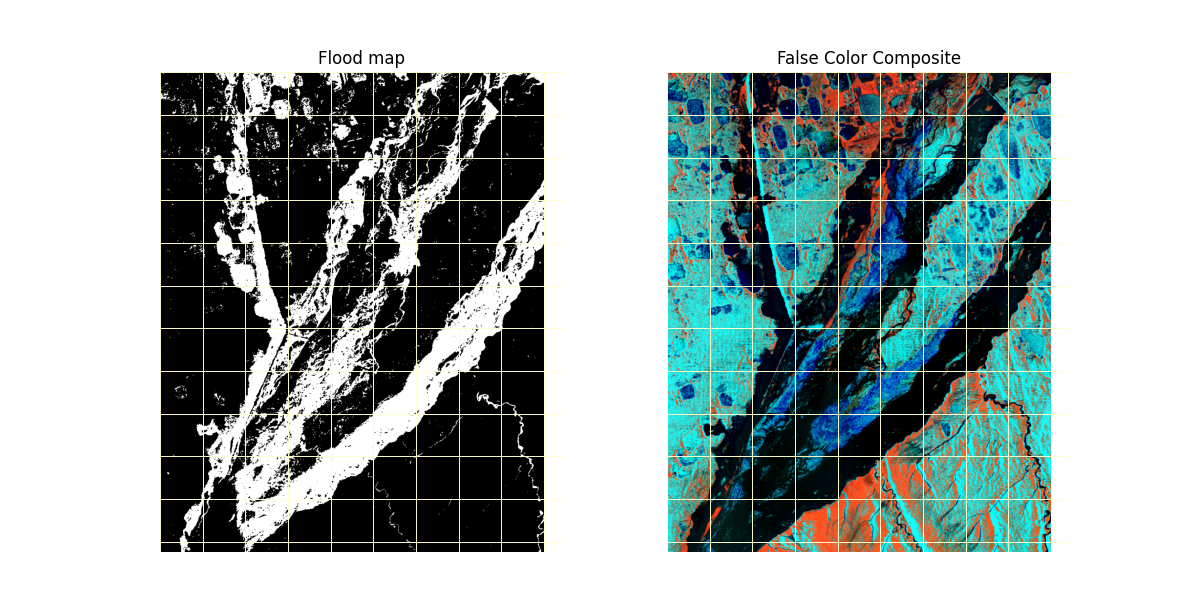

In [24]:
# Default threshold of 0.05
threshold = 0.05

# Creates the binary image and visualizes it
binary = threshold_image(refl_nir, threshold)
two_panel(binary, refl_natural, label='Flood map')

The detected flood area is shown in white. Those are the pixels whose NIR reflectance is below the threshold.

## Modify the threshold

Modify the threshold within the reasonable range we identified earlier. To this end, you can change the value in the second line below. For instance, to set it to 0.10, you can change it to

```
threshold = 0.10
```



Make a note of how the results change as you modify the threshold. You can hit the home button on the previous figure to facilitate comparisons.

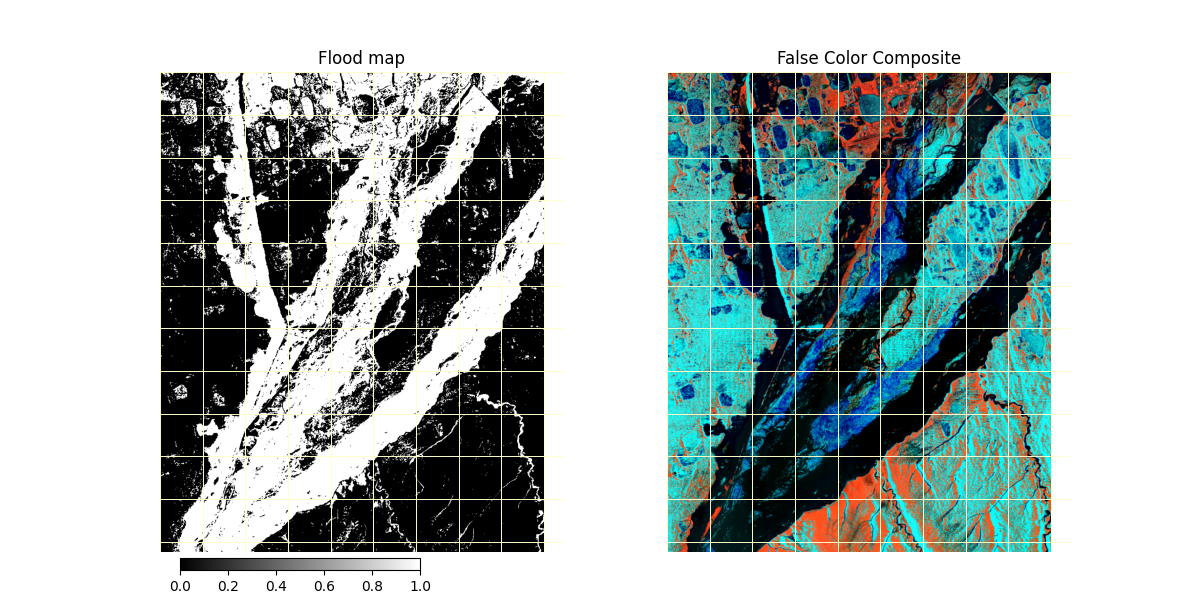

In [11]:
# User-defined threshold (modify as needed)
threshold = 0.20

# Creates the binary image and visualizes it
binary = threshold_image(refl_nir, threshold)
two_panel(binary, refl_natural, label='Flood map')

To test your understanding, return to the EdX platform.